In [35]:
# Import needed libraries
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

StatementMeta(ModelPrediction, 4, 35, Finished, Available, Finished)

#### Connecting to the cleaned and merged files from gold layer for Boston and Houston

In [36]:
# Set up Spark Config FIRST
storage_account_name = "team4storage"
storage_account_key = ""
container_name = "team4container"

spark.conf.set(
    f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net",
    storage_account_key
)

# Use wasbs:// instead of abfss://
Boston_folder_path = "Gold/ModelDataFiles/Boston_Model_Data.parquet"
Houston_folder_path = "Gold/ModelDataFiles/Houston_Model_Data.parquet"

# Read using wasbs
boston_df = spark.read.parquet(f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/{Boston_folder_path}")
houston_df = spark.read.parquet(f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/{Houston_folder_path}")

StatementMeta(ModelPrediction, 4, 36, Finished, Available, Finished)

In [15]:
boston_df.head()

StatementMeta(ModelPrediction, 4, 15, Finished, Available, Finished)

Row(Location='Boston', ed_trends_influenza='Decreasing', ed_trends_rsv='Decreasing', week_end=datetime.datetime(2023, 2, 4, 0, 0), total_visits_influenza=310000, total_visits_rsv=85250, total_visits_smoothed_combined=2201000.0, total_visits_smoothed_influenza=286750.0, total_visits_smoothed_rsv=77500.0, high_visits_influenza=0, high_visits_rsv=1, date=datetime.datetime(2023, 2, 4, 0, 0), avg_co=254.93, avg_no2=5.88, avg_o3=70.9, avg_so2=1.1, avg_pm2_5=0.83, avg_pm10=1.16, avg_us_aqi=88.0, high_pollution_events=13)

In [37]:
houston_df.head()

StatementMeta(ModelPrediction, 4, 37, Finished, Available, Finished)

Row(week_end=datetime.datetime(2023, 2, 4, 0, 0), ed_trends_influenza='Decreasing', ed_trends_rsv='Decreasing', total_visits_influenza=2805209, total_visits_rsv=951767, total_visits_smoothed_combined=12122511.0, total_visits_smoothed_influenza=2755116.0, total_visits_smoothed_rsv=1001860.0, Location='Houston', high_visits_influenza=1, high_visits_rsv=1, date=datetime.datetime(2023, 2, 4, 0, 0), avg_co=488.44, avg_no2=34.04, avg_o3=28.44, avg_so2=4.84, avg_pm2_5=18.18, avg_pm10=22.98, avg_us_aqi=64.0, high_pollution_events=1)

#### Adding lag variables to account for lag (Standard lag time assumed which is around 2-3 weeks)

In [38]:
# Define the window spec
window_spec = Window.partitionBy("Location").orderBy("week_end")

# Add 2-week lag and 3-week lag for target variables
boston_df = (
    boston_df
    .withColumn("total_visits_influenza_lag2", F.lag("total_visits_influenza", 2).over(window_spec))
    .withColumn("total_visits_influenza_lag3", F.lag("total_visits_influenza", 3).over(window_spec))
)

houston_df = (
    houston_df
    .withColumn("total_visits_influenza_lag2", F.lag("total_visits_influenza", 2).over(window_spec))
    .withColumn("total_visits_influenza_lag3", F.lag("total_visits_influenza", 3).over(window_spec))
)

StatementMeta(ModelPrediction, 4, 38, Finished, Available, Finished)

#### Feature engineering for the model 

In [44]:
feature_cols = [
    "avg_co", "avg_no2", "avg_o3", "avg_so2", 
    "avg_pm2_5", "avg_pm10", "avg_us_aqi", 
    "high_pollution_events", 
    "total_visits_influenza_lag2", 
    "total_visits_influenza_lag3"
]

target_col = "total_visits_influenza"

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"  
)

# Re-assemble
boston_prepared = assembler.transform(boston_df)
houston_prepared = assembler.transform(houston_df)

# Also, still drop the rows for lag2 and lag3 missing
boston_prepared = boston_prepared.dropna(subset=["total_visits_influenza_lag2", "total_visits_influenza_lag3"])
houston_prepared = houston_prepared.dropna(subset=["total_visits_influenza_lag2", "total_visits_influenza_lag3"])

StatementMeta(ModelPrediction, 4, 44, Finished, Available, Finished)

In [45]:
#test/tain split 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

boston_train, boston_test = boston_prepared.randomSplit([0.8, 0.2], seed=42)
houston_train, houston_test = houston_prepared.randomSplit([0.8, 0.2], seed=42)

StatementMeta(ModelPrediction, 4, 45, Finished, Available, Finished)

#### Linear Regression model and Random Forest Model to check RMSE scores

In [46]:
# Boston: Linear Regression
lr = LinearRegression(featuresCol="features", labelCol=target_col)
boston_model = lr.fit(boston_train)

# Houston: Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol=target_col, numTrees=100, maxDepth=5)
houston_rf_model = rf.fit(houston_train)

StatementMeta(ModelPrediction, 4, 46, Finished, Available, Finished)

In [47]:
boston_predictions = boston_model.transform(boston_test)
houston_rf_predictions = houston_rf_model.transform(houston_test)

StatementMeta(ModelPrediction, 4, 47, Finished, Available, Finished)

#### Interpreting the values and visualizing the baseline models

In [48]:
# Select for Visualization
boston_pred_df = boston_predictions.select("week_end", "total_visits_influenza", "prediction").toPandas()
houston_pred_df = houston_rf_predictions.select("week_end", "total_visits_influenza", "prediction").toPandas()

StatementMeta(ModelPrediction, 4, 48, Finished, Available, Finished)

StatementMeta(ModelPrediction, 4, 49, Finished, Available, Finished)

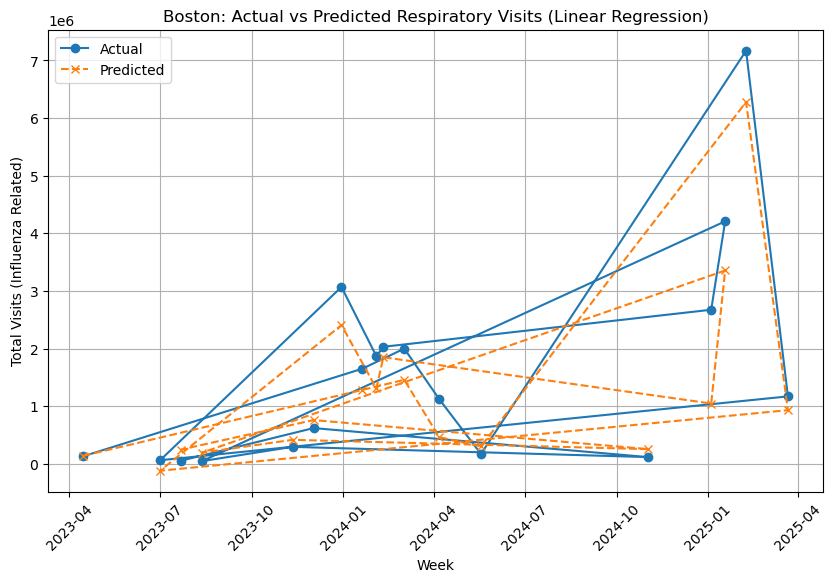

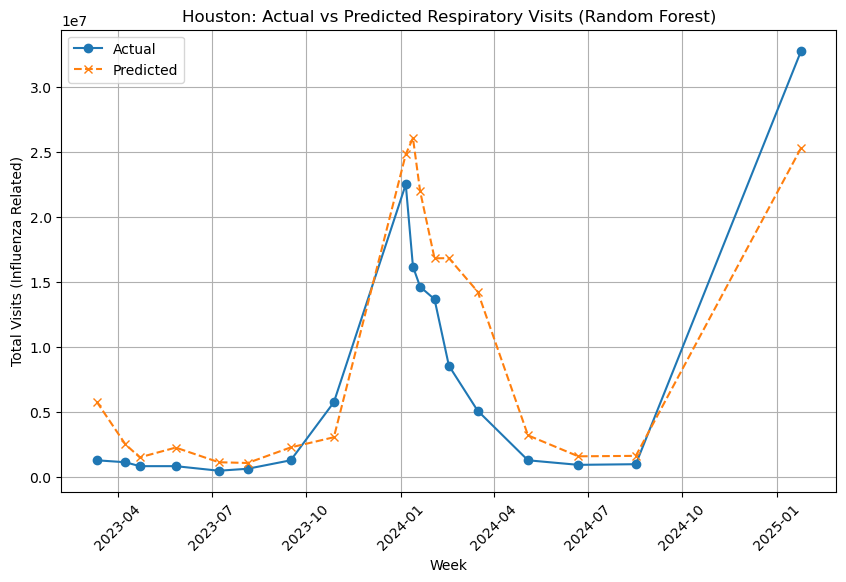

In [49]:
import matplotlib.pyplot as plt

# Boston Plot
plt.figure(figsize=(10,6))
plt.plot(boston_pred_df['week_end'], boston_pred_df['total_visits_influenza'], label='Actual', marker='o')
plt.plot(boston_pred_df['week_end'], boston_pred_df['prediction'], label='Predicted', linestyle='--', marker='x')
plt.title("Boston: Actual vs Predicted Respiratory Visits (Linear Regression)")
plt.xlabel("Week")
plt.ylabel("Total Visits (Influenza Related)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Houston Plot
plt.figure(figsize=(10,6))
plt.plot(houston_pred_df['week_end'], houston_pred_df['total_visits_influenza'], label='Actual', marker='o')
plt.plot(houston_pred_df['week_end'], houston_pred_df['prediction'], label='Predicted', linestyle='--', marker='x')
plt.title("Houston: Actual vs Predicted Respiratory Visits (Random Forest)")
plt.xlabel("Week")
plt.ylabel("Total Visits (Influenza Related)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


StatementMeta(ModelPrediction, 4, 50, Finished, Available, Finished)

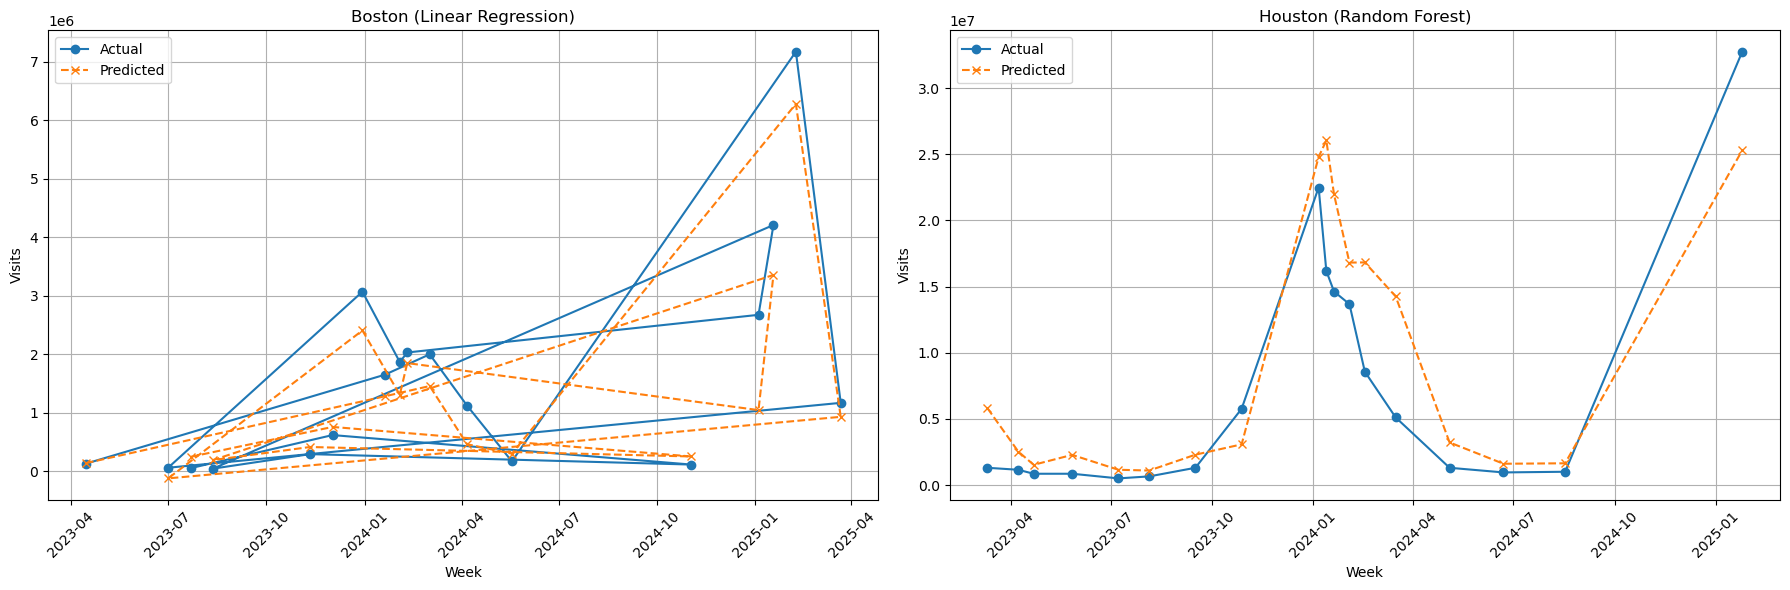

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(18,6))

# Boston
axs[0].plot(boston_pred_df['week_end'], boston_pred_df['total_visits_influenza'], label='Actual', marker='o')
axs[0].plot(boston_pred_df['week_end'], boston_pred_df['prediction'], label='Predicted', linestyle='--', marker='x')
axs[0].set_title("Boston (Linear Regression)")
axs[0].set_xlabel("Week")
axs[0].set_ylabel("Visits")
axs[0].legend()
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)

# Houston
axs[1].plot(houston_pred_df['week_end'], houston_pred_df['total_visits_influenza'], label='Actual', marker='o')
axs[1].plot(houston_pred_df['week_end'], houston_pred_df['prediction'], label='Predicted', linestyle='--', marker='x')
axs[1].set_title("Houston (Random Forest)")
axs[1].set_xlabel("Week")
axs[1].set_ylabel("Visits")
axs[1].legend()
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True)

plt.tight_layout()
plt.show()


### **Key Issues**
- Boston Linear Regression has random jumps
- Houston Random Forest still slightly lags during peak seasons
- Both models are directionally correct but have amplitude error

### **Summary of the baseline models**
- We have trained simple first models that predict respiratory-related hospital visits based on air quality trends.
- In both Boston and Houston, the models successfully capture when hospital visits rise or fall based on pollution patterns.
- While the models are not yet perfectly precise, they already provide strong evidence that air pollution is linked to changes in hospitalizations.